# Population Branch Statistics (PBS)

In [6]:
%run "imports.ipynb"

In [7]:
ac_biallel = zarr.open('data/phase2_biallel_allele_count.zarr')
outgroup_allele_counts= zarr.open('data/outgroup_alleles_phase2.zarr')
callset = callset_biallel

In [8]:
contigs = ['2R','2L','3R','3L', 'X']

----------------------------------------------

In [9]:
def pbs(chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    
    # load variant positions
    loc_pass_variants = callset[chrom]['variants/FILTER_PASS'][:]
    pos = callset[chrom]['variants/POS'][:][loc_pass_variants]
    
    # load allele counts
    ac1 = allel.AlleleCountsArray(ac_biallel[chrom][pop1])
    ac2 = allel.AlleleCountsArray(ac_biallel[chrom][pop2])
    ac3 = allel.AlleleCountsArray(outgroup_allele_counts[chrom][pop3])

    # locate segregating variants at sufficient frequency
    ac = ac1 + ac2 + ac3
    loc_seg = (ac.to_frequencies()[:, :2].min(axis=1) > min_maf)
    pos = pos[loc_seg]
    ac1 = ac1[loc_seg]
    ac2 = ac2[loc_seg]
    ac3 = ac3[loc_seg]
    
    # setup windows
    starts = allel.moving_statistic(pos, statistic=lambda v: v[0], size=window_size)
    starts[0] = 1  # fix to start of sequence
    ends = np.append(starts[1:] - 1, [np.max(pos)])

    # compute pbs
    res = allel.pbs(ac1, ac2, ac3, window_size=window_size, normed=normed)

    return starts, ends, res

def pbs_plot (chrom, pop1, pop2, pop3, window_size=100, min_maf=0.02, normed=True):
    starts, ends, y = pbs(chrom, pop1, pop2, pop3)
    fig, ax = plt.subplots(figsize=(14, 3))
    x = (starts + ends) / 2
    sns.despine(ax=ax, offset=10)
    ax.set_xlim(0, x.max())
    ax.plot(x, y, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
    ax.set_xlabel('Genome position (bp)')
    ax.set_ylabel('PBS');
    


def plot_genes_remastered(chrom, pos):
    plot_genes(genome, geneset_fn, chrom, pos-100, pos+100, label=True, label_rotation=90, height=0.5)
    
    
    
    
def locate_genes(chrom, value, pop1, pop2, pop3):    
    col_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    df = pd.read_csv('/home/jovyan/notebooks/data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz', compression='gzip',
                             sep='\t', comment='#', low_memory=False,
                             header=None, names=col_names)
    
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > value]
    
    df2 = pd.DataFrame([])
    for i in range(len(over30)):
        a=(df[(df.seqid == chrom) & (df.type == 'gene') & (df['start'] <= over30[i]-100) & (df['end'] >= over30[i]+100)])
        
        df2 = df2.append(a)
        df2.drop_duplicates(keep=False,inplace=True)

    log('Found', len(over30), 'SNPs with PBS values above', value, '\n', 'Total genes found:', len(df2))

    return df2




def plot_genes_pbs(chrom, pop1, pop2, pop3):
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > 0.2]
    print (over30)
    for i in range(len(over30)):
        plt.figure()
        plot_genes_remastered(chrom, over30[i])

## PBS by sympatric populations using <i>An.arabiensis</i> population as outgroup

### Chromosome 3R

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


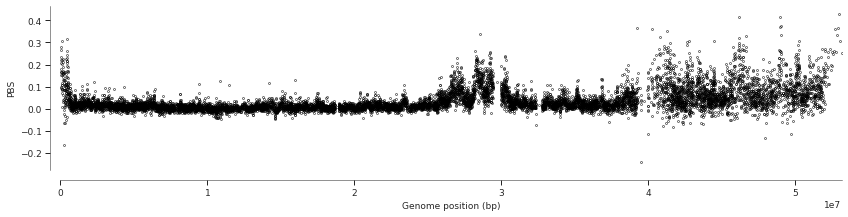

In [10]:
pbs_plot('3R', 'BFcol', 'BFgam', 'arab')

In [11]:
locate_genes('3R', 0.4, 'BFcol', 'BFgam', 'arab')

Found 3 SNPs with PBS values above 0.4 
 Total genes found: 1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


,seqid,source,type,start,end,score,strand,phase,attributes
155636,3R,VectorBase,gene,52903957,52937651,.,-,.,ID=AGAP010303;biotype=protein_coding


In [12]:
locate_genes('3R', 0.3, 'BFcol', 'BFgam', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 23 SNPs with PBS values above 0.3 
 Total genes found: 3


,seqid,source,type,start,end,score,strand,phase,attributes
119891,3R,VectorBase,gene,82151,142545,.,+,.,ID=AGAP007736;biotype=protein_coding
155628,3R,VectorBase,gene,52851999,52854757,.,-,.,ID=AGAP010302;biotype=protein_coding
155636,3R,VectorBase,gene,52903957,52937651,.,-,.,ID=AGAP010303;biotype=protein_coding


------------------------------

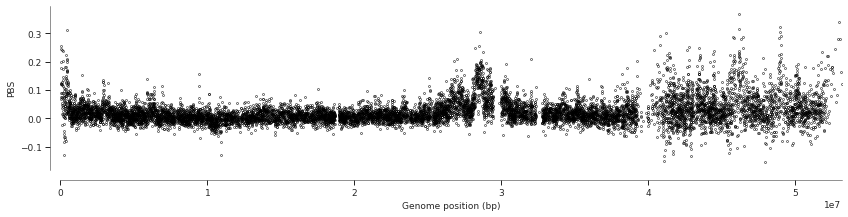

In [13]:
pbs_plot('3R', 'GHcol', 'GHgam', 'arab')

In [14]:
locate_genes('3R', 0.4, 'GHcol', 'GHgam', 'arab')

Found 0 SNPs with PBS values above 0.4 
 Total genes found: 0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


""


In [15]:
locate_genes('3R', 0.3, 'GHcol', 'GHgam', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 8 SNPs with PBS values above 0.3 
 Total genes found: 1


,seqid,source,type,start,end,score,strand,phase,attributes
155636,3R,VectorBase,gene,52903957,52937651,.,-,.,ID=AGAP010303;biotype=protein_coding


-------------------

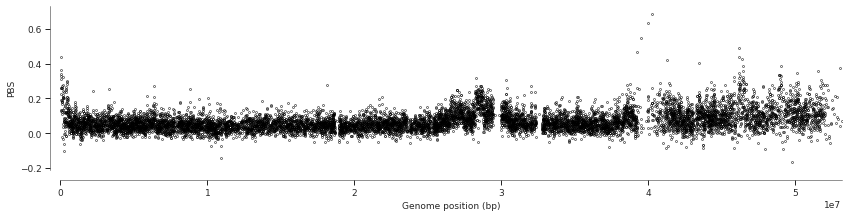

In [16]:
pbs_plot('3R', 'GNcol', 'GNgam', 'arab')

In [17]:
locate_genes('3R', 0.4, 'GNcol', 'GNgam', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 10 SNPs with PBS values above 0.4 
 Total genes found: 1


,seqid,source,type,start,end,score,strand,phase,attributes
147259,3R,VectorBase,gene,39950254,39970989,.,-,.,ID=AGAP009716;biotype=protein_coding


In [18]:
locate_genes('3R', 0.3, 'GNcol', 'GNgam', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 38 SNPs with PBS values above 0.3 
 Total genes found: 9


,seqid,source,type,start,end,score,strand,phase,attributes
119834,3R,VectorBase,gene,24056,39486,.,+,.,ID=AGAP007732;biotype=protein_coding
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
119939,3R,VectorBase,gene,172973,173928,.,+,.,ID=AGAP007740;biotype=protein_coding
141770,3R,VectorBase,gene,30300622,30308216,.,-,.,ID=AGAP009268;biotype=protein_coding
147259,3R,VectorBase,gene,39950254,39970989,.,-,.,ID=AGAP009716;biotype=protein_coding
150216,3R,VectorBase,gene,46148454,46164104,.,+,.,ID=AGAP009951;biotype=protein_coding
151981,3R,VectorBase,gene,48817865,48884835,.,-,.,ID=AGAP010090;biotype=protein_coding
154860,3R,VectorBase,gene,51727896,51751309,.,+,.,ID=AGAP010259;biotype=protein_coding
155659,3R,VectorBase,gene,52951761,52996140,.,+,.,ID=AGAP010304;biotype=protein_coding


In [19]:
locate_genes('3R', 0.2, 'GNcol', 'GNgam', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 365 SNPs with PBS values above 0.2 
 Total genes found: 53


,seqid,source,type,start,end,score,strand,phase,attributes
119861,3R,VectorBase,gene,39643,41560,.,+,.,ID=AGAP007733;biotype=protein_coding
119870,3R,VectorBase,gene,57849,62977,.,+,.,ID=AGAP007734;biotype=protein_coding
119939,3R,VectorBase,gene,172973,173928,.,+,.,ID=AGAP007740;biotype=protein_coding
119971,3R,VectorBase,gene,183531,191944,.,+,.,ID=AGAP007743;biotype=protein_coding
120029,3R,VectorBase,gene,228685,256328,.,+,.,ID=AGAP007751;biotype=protein_coding
123446,3R,VectorBase,gene,3273438,3275122,.,-,.,ID=AGAP007950;biotype=protein_coding
125986,3R,VectorBase,gene,5874203,5875164,.,-,.,ID=AGAP013737;biotype=protein_coding
126704,3R,VectorBase,gene,6376711,6377745,.,-,.,ID=AGAP008173;biotype=protein_coding
128369,3R,VectorBase,gene,8803846,8861386,.,-,.,ID=AGAP008305;biotype=protein_coding
128447,3R,VectorBase,gene,8838946,8852517,.,+,.,ID=AGAP008310;biotype=protein_coding


--------------------

## Test for coluzzii populations with Angola and arabiensis

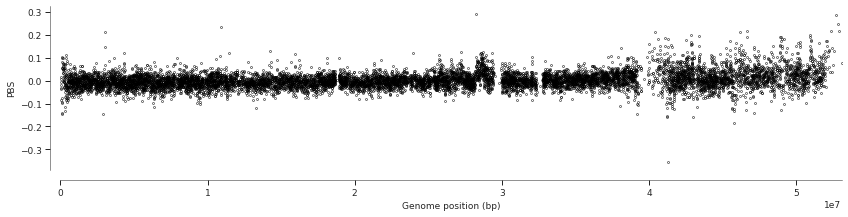

In [27]:
pbs_plot('3R', 'BFcol', 'AOcol', 'arab')

In [35]:
locate_genes('3R', 0.2, 'BFcol', 'AOcol', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 11 SNPs with PBS values above 0.2 
 Total genes found: 3


,seqid,source,type,start,end,score,strand,phase,attributes
130675,3R,VectorBase,gene,10915406,10917604,.,-,.,ID=AGAP008467;biotype=protein_coding
155602,3R,VectorBase,gene,52655670,52657280,.,+,.,ID=AGAP010298;biotype=protein_coding
155628,3R,VectorBase,gene,52851999,52854757,.,-,.,ID=AGAP010302;biotype=protein_coding


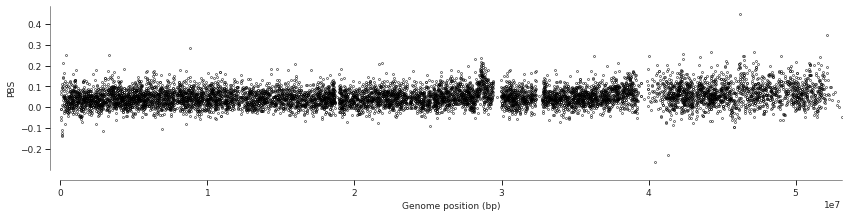

In [36]:
pbs_plot('3R', 'GNcol', 'AOcol', 'arab')

In [37]:
locate_genes('3R', 0.2, 'GNcol', 'AOcol', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 52 SNPs with PBS values above 0.2 
 Total genes found: 17


,seqid,source,type,start,end,score,strand,phase,attributes
123455,3R,VectorBase,gene,3275939,3278326,.,+,.,ID=AGAP007951;biotype=protein_coding
128369,3R,VectorBase,gene,8803846,8861386,.,-,.,ID=AGAP008305;biotype=protein_coding
128447,3R,VectorBase,gene,8838946,8852517,.,+,.,ID=AGAP008310;biotype=protein_coding
133965,3R,VectorBase,gene,15929030,15973388,.,-,.,ID=AGAP008712;biotype=protein_coding
140537,3R,VectorBase,gene,28576092,28590073,.,+,.,ID=AGAP009189;biotype=protein_coding
140746,3R,VectorBase,gene,28697024,28745886,.,-,.,ID=AGAP009207;biotype=protein_coding
140785,3R,VectorBase,gene,28747856,28807725,.,-,.,ID=AGAP009210;biotype=protein_coding
145485,3R,VectorBase,gene,36297895,36333175,.,+,.,ID=AGAP009566;biotype=protein_coding
147638,3R,VectorBase,gene,42077781,42087339,.,-,.,ID=AGAP009744;biotype=protein_coding
147741,3R,VectorBase,gene,42361196,42365395,.,+,.,ID=AGAP009752;biotype=protein_coding


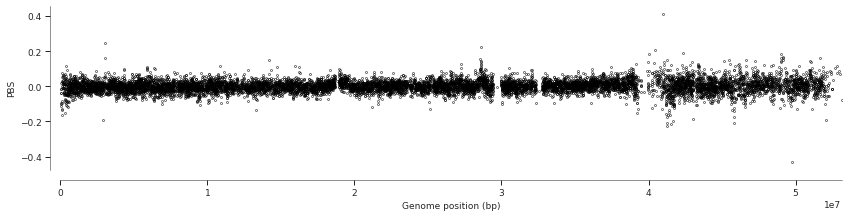

In [38]:
pbs_plot('3R', 'CIcol', 'AOcol', 'arab')

In [39]:
locate_genes('3R', 0.2, 'CIcol', 'AOcol', 'arab')

Found 4 SNPs with PBS values above 0.2 
 Total genes found: 1


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


,seqid,source,type,start,end,score,strand,phase,attributes
140583,3R,VectorBase,gene,28591663,28592475,.,-,.,ID=AGAP009190;biotype=protein_coding


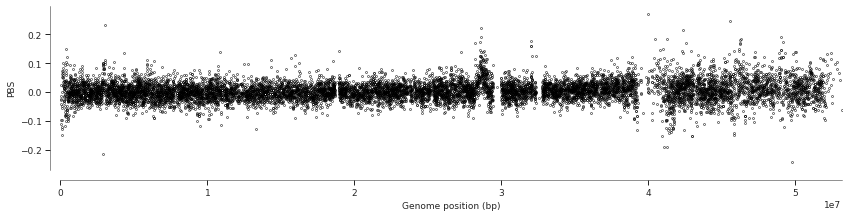

In [40]:
pbs_plot('3R', 'GHcol', 'AOcol', 'arab')

In [41]:
locate_genes('3R', 0.2, 'GHcol', 'AOcol', 'arab')

Found 5 SNPs with PBS values above 0.2 
 Total genes found: 0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


,seqid,source,type,start,end,score,strand,phase,attributes


# Angola vs Gabon

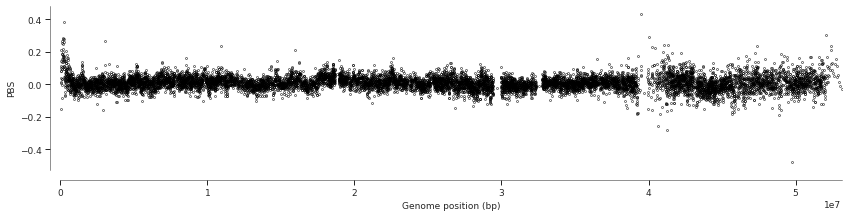

In [43]:
pbs_plot('3R', 'GAgam', 'AOcol', 'arab')

In [45]:
locate_genes('3R',0.2, 'GAgam', 'AOcol', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater


Found 25 SNPs with PBS values above 0.2 
 Total genes found: 9


,seqid,source,type,start,end,score,strand,phase,attributes
119911,3R,VectorBase,gene,149476,153955,.,+,.,ID=AGAP007737;biotype=protein_coding
119939,3R,VectorBase,gene,172973,173928,.,+,.,ID=AGAP007740;biotype=protein_coding
119983,3R,VectorBase,gene,195983,210038,.,-,.,ID=AGAP007744;biotype=protein_coding
120029,3R,VectorBase,gene,228685,256328,.,+,.,ID=AGAP007751;biotype=protein_coding
120104,3R,VectorBase,gene,267764,271254,.,-,.,ID=AGAP007753;biotype=protein_coding
120126,3R,VectorBase,gene,272627,279864,.,-,.,ID=AGAP007754;biotype=protein_coding
133965,3R,VectorBase,gene,15929030,15973388,.,-,.,ID=AGAP008712;biotype=protein_coding
155330,3R,VectorBase,gene,52042711,52059885,.,+,.,ID=AGAP010283;biotype=protein_coding
155544,3R,VectorBase,gene,52418651,52422892,.,-,.,ID=AGAP010294;biotype=protein_coding


## Sandbox - First time

In [12]:
pop_select = metadata.population.isin({'BFgam', 'BFcol', 'AOcol'}).values
pop_subset=metadata[pop_select]

In [13]:
genotypes_phase2_call = callset_phase2['3L']["calldata/GT"]
genotypes_phase2_call

<zarr.core.Array '/3L/calldata/GT' (10640388, 1142, 2) int8 read-only>

In [14]:
pos = allel.SortedIndex(callset_phase2["3L"]["variants/POS"])
pos

0,1,2,3,4,...,10640383,10640384,10640385,10640386,10640387
9790,9791,9798,9812,9815,...,41956532,41956537,41956541,41956551,41956556


In [15]:
genotypes_phase2 = allel.GenotypeDaskArray(genotypes_phase2_call)
genotypes_phase2

<GenotypeDaskArray shape=(10640388, 1142, 2) dtype=int8>

In [16]:
geno_p2_subset = genotypes_phase2.subset(sel1=pop_select)
geno_p2_subset

<GenotypeDaskArray shape=(10640388, 245, 2) dtype=int8>

In [17]:
grp = pop_subset.groupby("population")
grp_indices = grp.indices
ac_subpops = geno_p2_subset.count_alleles_subpops(grp_indices)

In [18]:
pbs = allel.pbs(ac_subpops['BFcol'], ac_subpops['BFgam'], ac_subpops['AOcol'], 1000)

In [22]:
x = allel.moving_statistic(pos, statistic=lambda v: v[0], size=1000)

In [23]:
len(x), len(pbs)

(10640, 10640)

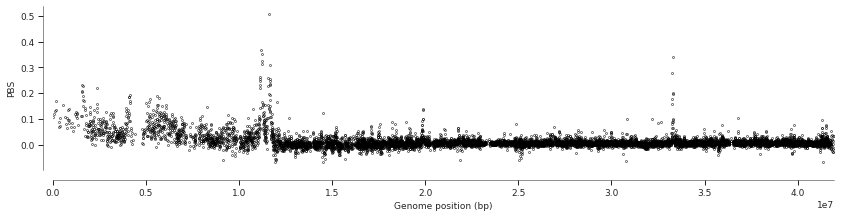

In [24]:
fig, ax = plt.subplots(figsize=(14, 3))
sns.despine(ax=ax, offset=10)
ax.plot(x, pbs, marker='o', linestyle=' ', mfc='none', mec='k', markersize=2)
ax.set_xlabel('Genome position (bp)')
ax.set_xlim(0, pos.max())
ax.set_ylabel('PBS');


In [25]:
x[pbs >0.30]

array([11166928, 11208561, 11218930, 11241787, 11590959, 11643851,
       33282415], dtype=int32)

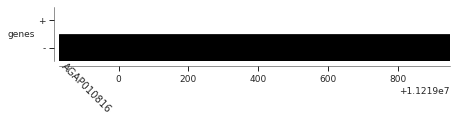

In [149]:
plot_genes(genome, geneset_fn, '3L', 11218830, 11219950, label=True, label_rotation=45, height=0.5)

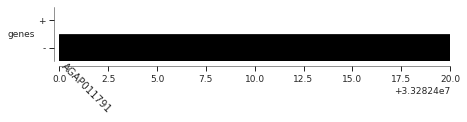

In [148]:
plot_genes(genome, geneset_fn, '3L', 33282400, 33282420, label=True, label_rotation=45, height=0.5)

Found these genes with PBS value above 0.30:
   - Gene: AGAP010816, Protein TEP3 - SNP Position 11218930
   - Gene: AGAP011791, Protein CLIPA1 - SNP Position 33282415

------------------------

In [164]:
def geneset_remastered(chrom, pos):   
    genes = get_geneset_features(geneset_fn, chrom, pos-100, pos+100).eq('type', 'gene').records()
    return genes

In [165]:
geneset_remastered('3L', 11218930)

('3L', 'VectorBase', 'gene', 11215246, 11220064, '.', '-', '.', {'ID': 'AGAP010816', 'biotype': 'protein_coding'})

In [216]:
def geneset_pbs(chrom, pop1, pop2, pop3):
    
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > 0.25]
    tbl=[]
    
    for i in range(len(over30)):

        a = (get_geneset_features(geneset_fn, chrom, over30[i]-insert, over30[i]+100).eq('type', 'gene').records())
        
    #table2 = etl.pushheader(tbl, ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'])
    #, columns =['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    #bl = pd.DataFrame(lst) 
    return tbl


In [133]:
def plot_genes_remastered(chrom, pos):
    plot_genes(genome, geneset_fn, chrom, pos-100, pos+100, label=True, label_rotation=45, height=0.5)

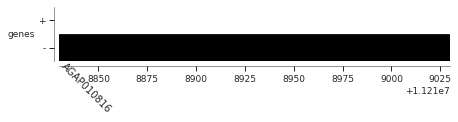

In [134]:
plot_genes_remastered('3L', 11218930)

In [120]:
def plot_genes_remastered(chrom, pos):
    plot_genes(genome, geneset_fn, chrom, pos-100, pos+100, label=True, label_rotation=45, height=0.5)

In [121]:
def plot_genes_pbs(chrom, pop1, pop2, pop3):
    
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > 0.25]
    print (over30)
    for i in range(len(over30)):
        plt.figure()
        plot_genes_remastered(chrom, over30[i])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


[  111880   121212   272465 38146011 39472026 40258889 43668516 43687557
 43691476 47942907 49112203 49721608]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:324: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

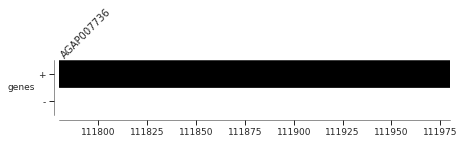

<Figure size 432x288 with 0 Axes>

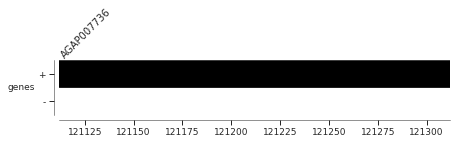

<Figure size 432x288 with 0 Axes>

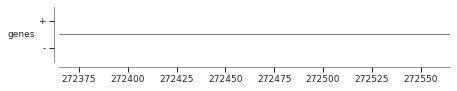

<Figure size 432x288 with 0 Axes>

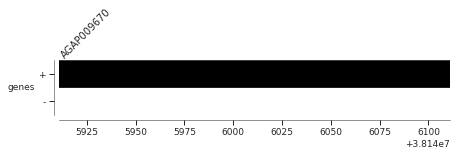

<Figure size 432x288 with 0 Axes>

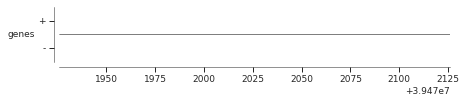

<Figure size 432x288 with 0 Axes>

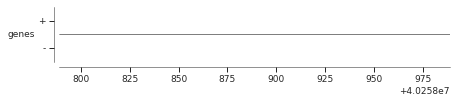

<Figure size 432x288 with 0 Axes>

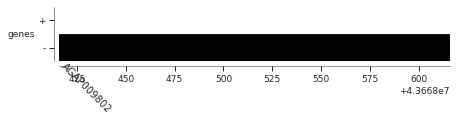

<Figure size 432x288 with 0 Axes>

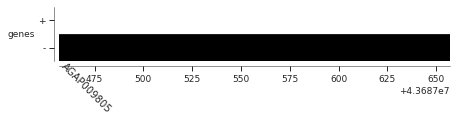

<Figure size 432x288 with 0 Axes>

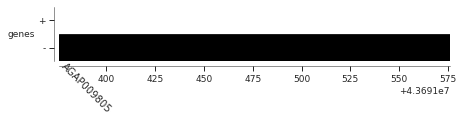

<Figure size 432x288 with 0 Axes>

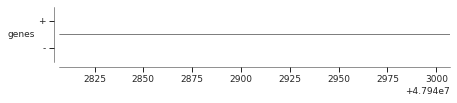

<Figure size 432x288 with 0 Axes>

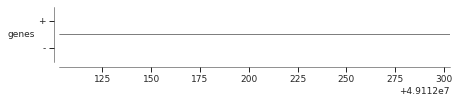

<Figure size 432x288 with 0 Axes>

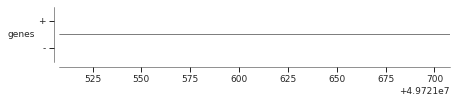

In [122]:
plot_genes_pbs('3R', 'BFgam', 'BFcol', 'arab')

-------------------------

In [140]:
import gffpandas.gffpandas as gffpd

In [ ]:
def locate_genes

In [61]:
col_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
df = pd.read_csv('/home/jovyan/notebooks/data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz', compression='gzip',
                         sep='\t', comment='#', low_memory=False,
                         header=None, names=col_names)


In [62]:
df.head()

,seqid,source,type,start,end,score,strand,phase,attributes
0,2L,VectorBase,contig,1,49364325,.,.,.,ID=2L;molecule_type=dsDNA;translation_table=1;...
1,2L,VectorBase,exon,157348,157623,.,-,.,ID=AGAP004677-RB-E4A;Parent=AGAP004677-RA
2,2L,VectorBase,exon,157348,157623,.,-,.,ID=AGAP004677-RB-E4B;Parent=AGAP004677-RB
3,2L,VectorBase,gene,157348,186936,.,-,.,ID=AGAP004677;biotype=protein_coding
4,2L,VectorBase,mRNA,157348,181305,.,-,.,ID=AGAP004677-RA;Parent=AGAP004677;Dbxref=RefS...


In [56]:
results = pbs('3L', 'BFgam', 'BFcol', 'arab')

/opt/conda/lib/python3.6/site-packages/allel/stats/fst.py:622: RuntimeWarning: invalid value encountered in true_divide
  fst = num_sum / den_sum


In [217]:
over30 = results[0][results[2] > 0.25]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [219]:
df[(df.seqid == '3R') & (df.type == 'gene') & (df['start'] <= over30[0]-100) & (df['end'] >= over30[0]+100)]

,seqid,source,type,start,end,score,strand,phase,attributes
129578,3R,VectorBase,gene,10236132,10238059,.,-,.,ID=AGAP008385;biotype=protein_coding


In [233]:
def locate_genes(chrom, pop1, pop2, pop3):    
    
    col_names = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    df = pd.read_csv('/home/jovyan/notebooks/data/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.sorted.gff3.gz', compression='gzip',
                             sep='\t', comment='#', low_memory=False,
                             header=None, names=col_names)
    
    results = pbs(chrom, pop1, pop2, pop3)
    over30 = results[0][results[2] > 0.25]
    df2 = pd.DataFrame([])
    for i in range(len(over30)):
        a=(df[(df.seqid == '3R') & (df.type == 'gene') & (df['start'] <= over30[i]-100) & (df['end'] >= over30[i]+100)])
        
        df2 = df2.append(a)
    return df2

In [234]:
locate_genes('3R', 'BFgam', 'BFcol', 'arab')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


,seqid,source,type,start,end,score,strand,phase,attributes
119891,3R,VectorBase,gene,82151,142545,.,+,.,ID=AGAP007736;biotype=protein_coding
119891,3R,VectorBase,gene,82151,142545,.,+,.,ID=AGAP007736;biotype=protein_coding
146803,3R,VectorBase,gene,38137217,38154470,.,+,.,ID=AGAP009670;biotype=protein_coding
148425,3R,VectorBase,gene,43667301,43668635,.,-,.,ID=AGAP009802;biotype=protein_coding
148473,3R,VectorBase,gene,43676455,43697706,.,-,.,ID=AGAP009805;biotype=protein_coding
148473,3R,VectorBase,gene,43676455,43697706,.,-,.,ID=AGAP009805;biotype=protein_coding
